In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/train"
val_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"
test_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 2000
Number of images in validation dataset: 600
Number of images in test dataset: 600


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
import torch.nn as nn
from torchvision.models import densenet201

class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier, self).__init__()
        self.backbone = densenet201(pretrained=True)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


In [7]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [8]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [10]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [11]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [12]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=db3e2fd3b9ab4392b86035ed1e08a84a133e89f9c0cca62b063211a56622ad2d
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=d0b4cb1f3e2d9b89f7b1b66ba1c3cc13fd13813ffeb83cbe7e111217e9c7a827
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import time
import copy

# Define snapshot ensemble function
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):

    ensemble_models = []
    snapshot_epochs = [30, 70, 120]
    best_snapshot_weights = None

    model = DenseNetClassifier(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    # FLOPs and parameter count
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    flops = FlopCountAnalysis(model, sample_input)
    print("Model FLOPs and Parameter Count:")
    print(parameter_count_table(model))
    print(f"Total FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

    criterion = CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)

    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)

        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/{total_epochs}, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)

        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

        # Validation phase
        model.eval()
        torch.cuda.reset_peak_memory_stats(device)
        start_time = time.time()

        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        end_time = time.time()
        inference_time = end_time - start_time
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        print(f"Validation Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)

        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []

            start_time = time.time()
            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
            end_time = time.time()

            inference_time = end_time - start_time
            memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            print(f"Test Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)

            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()

        scheduler.step()

    return ensemble_models


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 207MB/s]


Using 2 GPUs!
Model FLOPs and Parameter Count:
| name                          | #elements or shape   |
|:------------------------------|:---------------------|
| model                         | 18.1M                |
|  module                       |  18.1M               |
|   module.backbone             |   18.1M              |
|    module.backbone.features   |    18.1M             |
|    module.backbone.classifier |    5.8K              |
Total FLOPs: 4.41 GFLOPs
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120: 100%|██████████| 16/16 [00:33<00:00,  2.09s/it]


Train Loss: 0.2735, Accuracy: 0.6680, Precision: 0.7112, Recall: 0.6680, F1 Score: 0.6586


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Validation Inference Time: 6.66 sec, Peak GPU Memory: 1046.20 MB
Validation Loss: 0.2654, Accuracy: 0.7033, Precision: 0.7191, Recall: 0.7033, F1 Score: 0.6850
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120: 100%|██████████| 16/16 [00:28<00:00,  1.75s/it]


Train Loss: 0.1396, Accuracy: 0.8940, Precision: 0.8956, Recall: 0.8940, F1 Score: 0.8883


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.19 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2411, Accuracy: 0.7450, Precision: 0.7322, Recall: 0.7450, F1 Score: 0.7293
Best model updated based on validation accuracy
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]


Train Loss: 0.1065, Accuracy: 0.9765, Precision: 0.9767, Recall: 0.9765, F1 Score: 0.9762


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Validation Inference Time: 3.82 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2376, Accuracy: 0.7483, Precision: 0.7330, Recall: 0.7483, F1 Score: 0.7334
Best model updated based on validation accuracy
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


Train Loss: 0.0936, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Validation Inference Time: 3.33 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2340, Accuracy: 0.7467, Precision: 0.7389, Recall: 0.7467, F1 Score: 0.7349
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Train Loss: 0.0885, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Validation Inference Time: 3.58 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2342, Accuracy: 0.7383, Precision: 0.7404, Recall: 0.7383, F1 Score: 0.7342
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


Train Loss: 0.0867, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Validation Inference Time: 4.46 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2419, Accuracy: 0.7433, Precision: 0.7306, Recall: 0.7433, F1 Score: 0.7254
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120: 100%|██████████| 16/16 [00:26<00:00,  1.69s/it]


Train Loss: 0.0855, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Validation Inference Time: 4.68 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2348, Accuracy: 0.7433, Precision: 0.7364, Recall: 0.7433, F1 Score: 0.7324
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120: 100%|██████████| 16/16 [00:29<00:00,  1.84s/it]


Train Loss: 0.0842, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.61 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2290, Accuracy: 0.7500, Precision: 0.7401, Recall: 0.7500, F1 Score: 0.7378
Best model updated based on validation accuracy
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120: 100%|██████████| 16/16 [00:29<00:00,  1.85s/it]


Train Loss: 0.0835, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Validation Inference Time: 4.27 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2272, Accuracy: 0.7350, Precision: 0.7258, Recall: 0.7350, F1 Score: 0.7269
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Train Loss: 0.0830, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Validation Inference Time: 5.14 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2301, Accuracy: 0.7433, Precision: 0.7368, Recall: 0.7433, F1 Score: 0.7342
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Train Loss: 0.0822, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Validation Inference Time: 3.70 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2251, Accuracy: 0.7367, Precision: 0.7347, Recall: 0.7367, F1 Score: 0.7325
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Train Loss: 0.0815, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Validation Inference Time: 3.65 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2253, Accuracy: 0.7567, Precision: 0.7458, Recall: 0.7567, F1 Score: 0.7444
Best model updated based on validation accuracy
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Train Loss: 0.0812, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Validation Inference Time: 3.48 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2238, Accuracy: 0.7417, Precision: 0.7299, Recall: 0.7417, F1 Score: 0.7316
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Train Loss: 0.0810, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Validation Inference Time: 5.36 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2219, Accuracy: 0.7567, Precision: 0.7477, Recall: 0.7567, F1 Score: 0.7463
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120: 100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Train Loss: 0.0800, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Validation Inference Time: 3.62 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2207, Accuracy: 0.7517, Precision: 0.7383, Recall: 0.7517, F1 Score: 0.7408
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it]


Train Loss: 0.0790, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Validation Inference Time: 3.71 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2232, Accuracy: 0.7467, Precision: 0.7336, Recall: 0.7467, F1 Score: 0.7347
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


Train Loss: 0.0784, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Validation Inference Time: 3.54 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2182, Accuracy: 0.7433, Precision: 0.7363, Recall: 0.7433, F1 Score: 0.7364
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


Train Loss: 0.0780, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Validation Inference Time: 4.94 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2151, Accuracy: 0.7467, Precision: 0.7344, Recall: 0.7467, F1 Score: 0.7382
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120: 100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


Train Loss: 0.0776, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Validation Inference Time: 7.82 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2194, Accuracy: 0.7500, Precision: 0.7432, Recall: 0.7500, F1 Score: 0.7416
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120: 100%|██████████| 16/16 [00:37<00:00,  2.31s/it]


Train Loss: 0.0767, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Validation Inference Time: 7.57 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2165, Accuracy: 0.7400, Precision: 0.7342, Recall: 0.7400, F1 Score: 0.7338
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120: 100%|██████████| 16/16 [00:32<00:00,  2.05s/it]


Train Loss: 0.0761, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Validation Inference Time: 3.44 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2131, Accuracy: 0.7417, Precision: 0.7348, Recall: 0.7417, F1 Score: 0.7362
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120: 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


Train Loss: 0.0753, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Validation Inference Time: 3.42 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2109, Accuracy: 0.7550, Precision: 0.7447, Recall: 0.7550, F1 Score: 0.7479
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Train Loss: 0.0749, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Validation Inference Time: 5.17 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2137, Accuracy: 0.7417, Precision: 0.7356, Recall: 0.7417, F1 Score: 0.7354
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


Train Loss: 0.0745, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Validation Inference Time: 3.83 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2142, Accuracy: 0.7400, Precision: 0.7353, Recall: 0.7400, F1 Score: 0.7340
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]


Train Loss: 0.0736, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Validation Inference Time: 3.83 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2142, Accuracy: 0.7500, Precision: 0.7421, Recall: 0.7500, F1 Score: 0.7411
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


Train Loss: 0.0730, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Validation Inference Time: 4.01 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2073, Accuracy: 0.7467, Precision: 0.7410, Recall: 0.7467, F1 Score: 0.7425
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


Train Loss: 0.0722, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Validation Inference Time: 3.71 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2105, Accuracy: 0.7467, Precision: 0.7390, Recall: 0.7467, F1 Score: 0.7392
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Train Loss: 0.0719, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Validation Inference Time: 3.50 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2060, Accuracy: 0.7433, Precision: 0.7355, Recall: 0.7433, F1 Score: 0.7371
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Train Loss: 0.0713, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Validation Inference Time: 5.07 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2077, Accuracy: 0.7483, Precision: 0.7375, Recall: 0.7483, F1 Score: 0.7391
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


Train Loss: 0.0708, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Validation Inference Time: 3.65 sec, Peak GPU Memory: 1116.28 MB
Validation Loss: 0.2071, Accuracy: 0.7450, Precision: 0.7343, Recall: 0.7450, F1 Score: 0.7361
Snapshot 0 saved


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Test Inference Time: 3.68 sec, Peak GPU Memory: 1186.37 MB
Test Loss: 0.2086, Accuracy: 0.7567, Precision: 0.7458, Recall: 0.7567, F1 Score: 0.7444
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.64      0.40      0.49       117
           1       0.81      0.90      0.85       393
           2       0.59      0.61      0.60        90

    accuracy                           0.76       600
   macro avg       0.68      0.64      0.65       600
weighted avg       0.75      0.76      0.74       600



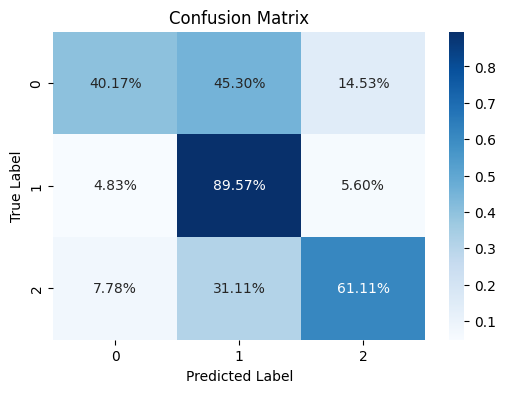

Test Sensitivity: 0.9488, Test Specificity: 0.4700


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


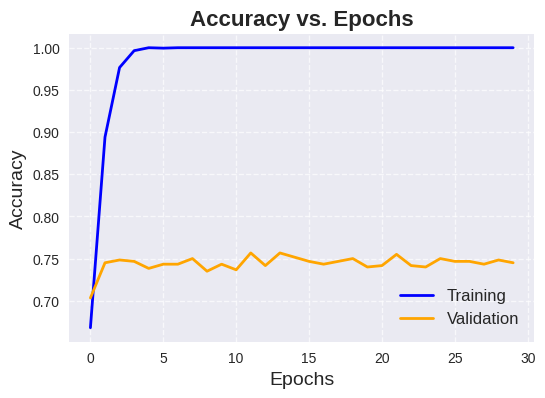

<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


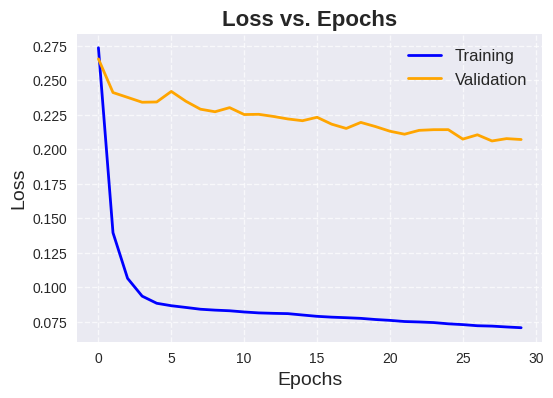

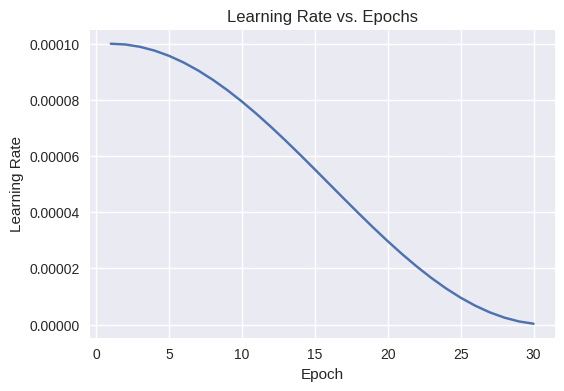

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Train Loss: 0.0721, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Validation Inference Time: 3.72 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2340, Accuracy: 0.7100, Precision: 0.7073, Recall: 0.7100, F1 Score: 0.6963
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it]


Train Loss: 0.0762, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Inference Time: 6.05 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2290, Accuracy: 0.7400, Precision: 0.7554, Recall: 0.7400, F1 Score: 0.7403
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120: 100%|██████████| 16/16 [00:32<00:00,  2.03s/it]


Train Loss: 0.0740, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Inference Time: 5.96 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2116, Accuracy: 0.7617, Precision: 0.7519, Recall: 0.7617, F1 Score: 0.7477
Best model updated based on validation accuracy
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120: 100%|██████████| 16/16 [00:32<00:00,  2.06s/it]


Train Loss: 0.0724, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Inference Time: 5.90 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2285, Accuracy: 0.7383, Precision: 0.7279, Recall: 0.7383, F1 Score: 0.7281
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120: 100%|██████████| 16/16 [00:31<00:00,  1.98s/it]


Train Loss: 0.0699, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.72 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2066, Accuracy: 0.7633, Precision: 0.7599, Recall: 0.7633, F1 Score: 0.7611
Best model updated based on validation accuracy
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120: 100%|██████████| 16/16 [00:32<00:00,  2.05s/it]


Train Loss: 0.0705, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Inference Time: 5.89 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2153, Accuracy: 0.7267, Precision: 0.7498, Recall: 0.7267, F1 Score: 0.7347
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120: 100%|██████████| 16/16 [00:35<00:00,  2.24s/it]


Train Loss: 0.0681, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Validation Inference Time: 6.44 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2068, Accuracy: 0.7400, Precision: 0.7495, Recall: 0.7400, F1 Score: 0.7414
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120: 100%|██████████| 16/16 [00:32<00:00,  2.01s/it]


Train Loss: 0.0666, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.59 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2108, Accuracy: 0.7400, Precision: 0.7451, Recall: 0.7400, F1 Score: 0.7360
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it]


Train Loss: 0.0656, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Validation Inference Time: 4.08 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1965, Accuracy: 0.7650, Precision: 0.7589, Recall: 0.7650, F1 Score: 0.7592
Best model updated based on validation accuracy
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Train Loss: 0.0647, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Validation Inference Time: 3.78 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1995, Accuracy: 0.7567, Precision: 0.7517, Recall: 0.7567, F1 Score: 0.7520
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 41/120: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Train Loss: 0.0645, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Validation Inference Time: 3.73 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2057, Accuracy: 0.7733, Precision: 0.7638, Recall: 0.7733, F1 Score: 0.7601
Best model updated based on validation accuracy
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120: 100%|██████████| 16/16 [00:27<00:00,  1.75s/it]


Train Loss: 0.0633, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Validation Inference Time: 3.73 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1993, Accuracy: 0.7667, Precision: 0.7643, Recall: 0.7667, F1 Score: 0.7593
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Train Loss: 0.0626, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Validation Inference Time: 3.66 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1917, Accuracy: 0.7617, Precision: 0.7617, Recall: 0.7617, F1 Score: 0.7575
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Train Loss: 0.0618, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Validation Inference Time: 4.18 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.2055, Accuracy: 0.7483, Precision: 0.7478, Recall: 0.7483, F1 Score: 0.7377
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Train Loss: 0.0612, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Validation Inference Time: 3.99 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1938, Accuracy: 0.7617, Precision: 0.7630, Recall: 0.7617, F1 Score: 0.7580
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Train Loss: 0.0604, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Validation Inference Time: 3.71 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1937, Accuracy: 0.7450, Precision: 0.7509, Recall: 0.7450, F1 Score: 0.7441
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Train Loss: 0.0598, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Validation Inference Time: 3.89 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1953, Accuracy: 0.7617, Precision: 0.7587, Recall: 0.7617, F1 Score: 0.7534
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120: 100%|██████████| 16/16 [00:31<00:00,  1.94s/it]


Train Loss: 0.0590, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Validation Inference Time: 4.38 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1888, Accuracy: 0.7517, Precision: 0.7575, Recall: 0.7517, F1 Score: 0.7511
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Train Loss: 0.0582, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Validation Inference Time: 3.70 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1872, Accuracy: 0.7533, Precision: 0.7574, Recall: 0.7533, F1 Score: 0.7522
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Train Loss: 0.0576, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Validation Inference Time: 3.73 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1935, Accuracy: 0.7550, Precision: 0.7574, Recall: 0.7550, F1 Score: 0.7502
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Train Loss: 0.0571, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Validation Inference Time: 3.65 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1913, Accuracy: 0.7533, Precision: 0.7602, Recall: 0.7533, F1 Score: 0.7504
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Train Loss: 0.0563, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Validation Inference Time: 3.85 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1912, Accuracy: 0.7583, Precision: 0.7584, Recall: 0.7583, F1 Score: 0.7509
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Train Loss: 0.0557, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Validation Inference Time: 3.67 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1899, Accuracy: 0.7550, Precision: 0.7574, Recall: 0.7550, F1 Score: 0.7502
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120: 100%|██████████| 16/16 [00:25<00:00,  1.56s/it]


Train Loss: 0.0550, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Validation Inference Time: 3.70 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1870, Accuracy: 0.7550, Precision: 0.7604, Recall: 0.7550, F1 Score: 0.7527
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120: 100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


Train Loss: 0.0545, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Validation Inference Time: 3.54 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1889, Accuracy: 0.7583, Precision: 0.7535, Recall: 0.7583, F1 Score: 0.7497
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


Train Loss: 0.0535, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Validation Inference Time: 3.65 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1864, Accuracy: 0.7517, Precision: 0.7593, Recall: 0.7517, F1 Score: 0.7509
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Train Loss: 0.0529, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Validation Inference Time: 3.49 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1843, Accuracy: 0.7567, Precision: 0.7605, Recall: 0.7567, F1 Score: 0.7537
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Train Loss: 0.0522, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Validation Inference Time: 5.07 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1821, Accuracy: 0.7533, Precision: 0.7637, Recall: 0.7533, F1 Score: 0.7546
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Train Loss: 0.0516, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Validation Inference Time: 3.54 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1800, Accuracy: 0.7650, Precision: 0.7656, Recall: 0.7650, F1 Score: 0.7605
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Train Loss: 0.0510, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Validation Inference Time: 3.64 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1828, Accuracy: 0.7667, Precision: 0.7610, Recall: 0.7667, F1 Score: 0.7572
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Train Loss: 0.0502, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Validation Inference Time: 3.51 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1786, Accuracy: 0.7717, Precision: 0.7631, Recall: 0.7717, F1 Score: 0.7624
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Train Loss: 0.0497, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Validation Inference Time: 3.81 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1816, Accuracy: 0.7483, Precision: 0.7560, Recall: 0.7483, F1 Score: 0.7467
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Train Loss: 0.0490, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Validation Inference Time: 3.92 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1752, Accuracy: 0.7700, Precision: 0.7670, Recall: 0.7700, F1 Score: 0.7644
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120: 100%|██████████| 16/16 [00:29<00:00,  1.87s/it]


Train Loss: 0.0481, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Validation Inference Time: 4.87 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1742, Accuracy: 0.7650, Precision: 0.7595, Recall: 0.7650, F1 Score: 0.7588
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Train Loss: 0.0474, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Validation Inference Time: 4.67 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1752, Accuracy: 0.7483, Precision: 0.7556, Recall: 0.7483, F1 Score: 0.7472
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Train Loss: 0.0466, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Validation Inference Time: 3.72 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1727, Accuracy: 0.7667, Precision: 0.7638, Recall: 0.7667, F1 Score: 0.7609
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Train Loss: 0.0459, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Validation Inference Time: 3.81 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1754, Accuracy: 0.7633, Precision: 0.7613, Recall: 0.7633, F1 Score: 0.7564
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120: 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


Train Loss: 0.0454, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Validation Inference Time: 3.88 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1711, Accuracy: 0.7633, Precision: 0.7649, Recall: 0.7633, F1 Score: 0.7597
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120: 100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Train Loss: 0.0448, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Validation Inference Time: 3.54 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1711, Accuracy: 0.7583, Precision: 0.7615, Recall: 0.7583, F1 Score: 0.7551
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120: 100%|██████████| 16/16 [00:28<00:00,  1.79s/it]


Train Loss: 0.0440, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Validation Inference Time: 4.73 sec, Peak GPU Memory: 1186.37 MB
Validation Loss: 0.1712, Accuracy: 0.7650, Precision: 0.7648, Recall: 0.7650, F1 Score: 0.7596
Snapshot 1 saved


Testing: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Test Inference Time: 4.13 sec, Peak GPU Memory: 1256.45 MB
Test Loss: 0.1679, Accuracy: 0.7733, Precision: 0.7638, Recall: 0.7733, F1 Score: 0.7601
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.69      0.41      0.51       117
           1       0.82      0.91      0.86       393
           2       0.64      0.66      0.65        90

    accuracy                           0.77       600
   macro avg       0.71      0.66      0.67       600
weighted avg       0.76      0.77      0.76       600



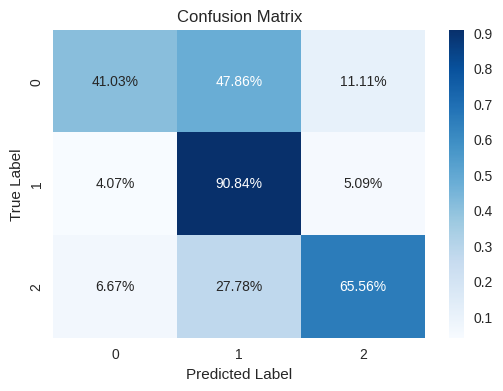

Test Sensitivity: 0.9571, Test Specificity: 0.4615


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


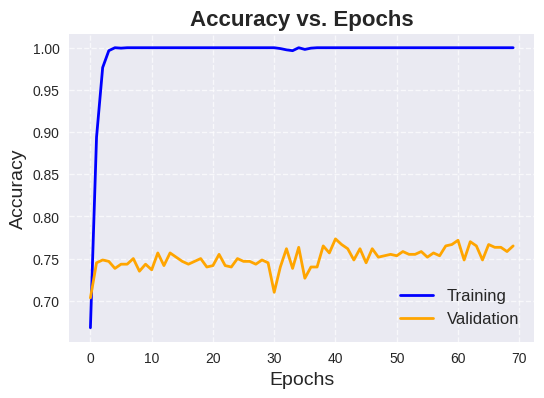

<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


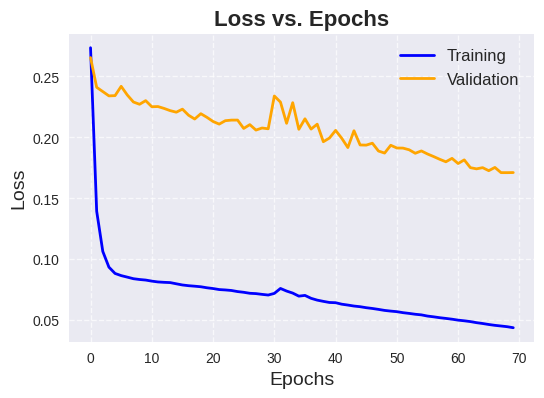

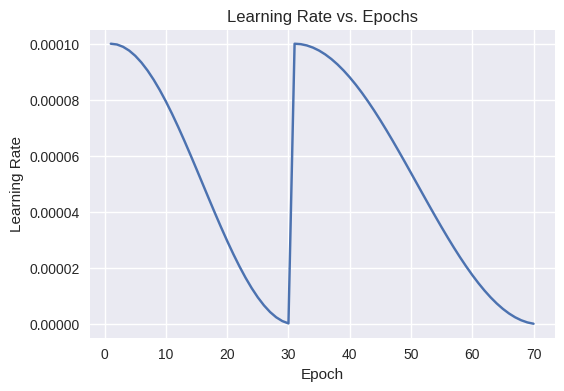

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Train Loss: 0.0449, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Validation Inference Time: 3.82 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1852, Accuracy: 0.7467, Precision: 0.7376, Recall: 0.7467, F1 Score: 0.7279
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it]


Train Loss: 0.0453, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Validation Inference Time: 4.04 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1815, Accuracy: 0.7283, Precision: 0.7534, Recall: 0.7283, F1 Score: 0.7372
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Train Loss: 0.0444, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Validation Inference Time: 4.70 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1741, Accuracy: 0.7683, Precision: 0.7625, Recall: 0.7683, F1 Score: 0.7634
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


Train Loss: 0.0428, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Validation Inference Time: 4.12 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1710, Accuracy: 0.7650, Precision: 0.7706, Recall: 0.7650, F1 Score: 0.7672
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120: 100%|██████████| 16/16 [00:27<00:00,  1.75s/it]


Train Loss: 0.0429, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Validation Inference Time: 3.70 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1908, Accuracy: 0.7467, Precision: 0.7426, Recall: 0.7467, F1 Score: 0.7342
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Train Loss: 0.0412, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Validation Inference Time: 4.99 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1734, Accuracy: 0.7350, Precision: 0.7355, Recall: 0.7350, F1 Score: 0.7213
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Train Loss: 0.0401, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Validation Inference Time: 5.85 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1800, Accuracy: 0.7350, Precision: 0.7548, Recall: 0.7350, F1 Score: 0.7327
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Train Loss: 0.0391, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Validation Inference Time: 5.08 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1652, Accuracy: 0.7650, Precision: 0.7570, Recall: 0.7650, F1 Score: 0.7583
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Train Loss: 0.0380, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Validation Inference Time: 4.19 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1672, Accuracy: 0.7583, Precision: 0.7518, Recall: 0.7583, F1 Score: 0.7477
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120: 100%|██████████| 16/16 [00:26<00:00,  1.69s/it]


Train Loss: 0.0371, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Validation Inference Time: 4.86 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1700, Accuracy: 0.7483, Precision: 0.7425, Recall: 0.7483, F1 Score: 0.7391
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120: 100%|██████████| 16/16 [00:32<00:00,  2.01s/it]


Train Loss: 0.0361, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.45 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1626, Accuracy: 0.7667, Precision: 0.7575, Recall: 0.7667, F1 Score: 0.7571
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


Train Loss: 0.0352, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Inference Time: 5.92 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1659, Accuracy: 0.7600, Precision: 0.7583, Recall: 0.7600, F1 Score: 0.7538
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


Train Loss: 0.0346, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Validation Inference Time: 3.66 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1664, Accuracy: 0.7633, Precision: 0.7554, Recall: 0.7633, F1 Score: 0.7493
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


Train Loss: 0.0338, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Validation Inference Time: 4.31 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1640, Accuracy: 0.7617, Precision: 0.7531, Recall: 0.7617, F1 Score: 0.7479
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Train Loss: 0.0330, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Validation Inference Time: 3.59 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1626, Accuracy: 0.7617, Precision: 0.7587, Recall: 0.7617, F1 Score: 0.7565
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


Train Loss: 0.0322, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Validation Inference Time: 3.60 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1613, Accuracy: 0.7650, Precision: 0.7599, Recall: 0.7650, F1 Score: 0.7571
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Train Loss: 0.0314, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Validation Inference Time: 3.55 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1684, Accuracy: 0.7483, Precision: 0.7525, Recall: 0.7483, F1 Score: 0.7390
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


Train Loss: 0.0315, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Validation Inference Time: 3.73 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1729, Accuracy: 0.7483, Precision: 0.7493, Recall: 0.7483, F1 Score: 0.7326
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


Train Loss: 0.0320, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Validation Inference Time: 3.90 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1693, Accuracy: 0.7583, Precision: 0.7526, Recall: 0.7583, F1 Score: 0.7449
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


Train Loss: 0.0304, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Validation Inference Time: 4.24 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1763, Accuracy: 0.7250, Precision: 0.7349, Recall: 0.7250, F1 Score: 0.7262
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120: 100%|██████████| 16/16 [00:31<00:00,  1.98s/it]


Train Loss: 0.0289, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Validation Inference Time: 6.49 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1612, Accuracy: 0.7583, Precision: 0.7503, Recall: 0.7583, F1 Score: 0.7526
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120: 100%|██████████| 16/16 [00:30<00:00,  1.89s/it]


Train Loss: 0.0280, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Validation Inference Time: 5.32 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1783, Accuracy: 0.7333, Precision: 0.7430, Recall: 0.7333, F1 Score: 0.7288
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Train Loss: 0.0271, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Validation Inference Time: 4.63 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1624, Accuracy: 0.7667, Precision: 0.7551, Recall: 0.7667, F1 Score: 0.7548
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it]


Train Loss: 0.0260, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Validation Inference Time: 4.55 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1591, Accuracy: 0.7750, Precision: 0.7677, Recall: 0.7750, F1 Score: 0.7657
Best model updated based on validation accuracy
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Train Loss: 0.0252, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Validation Inference Time: 4.93 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1613, Accuracy: 0.7633, Precision: 0.7568, Recall: 0.7633, F1 Score: 0.7545
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120: 100%|██████████| 16/16 [00:30<00:00,  1.94s/it]


Train Loss: 0.0244, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Validation Inference Time: 4.12 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1590, Accuracy: 0.7600, Precision: 0.7487, Recall: 0.7600, F1 Score: 0.7502
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Train Loss: 0.0236, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.64 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1628, Accuracy: 0.7550, Precision: 0.7502, Recall: 0.7550, F1 Score: 0.7488
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120: 100%|██████████| 16/16 [00:32<00:00,  2.01s/it]


Train Loss: 0.0227, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Validation Inference Time: 4.18 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1615, Accuracy: 0.7517, Precision: 0.7516, Recall: 0.7517, F1 Score: 0.7469
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Train Loss: 0.0217, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Validation Inference Time: 3.90 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1616, Accuracy: 0.7483, Precision: 0.7481, Recall: 0.7483, F1 Score: 0.7413
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Train Loss: 0.0209, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Validation Inference Time: 4.32 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1593, Accuracy: 0.7683, Precision: 0.7596, Recall: 0.7683, F1 Score: 0.7579
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


Train Loss: 0.0201, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Validation Inference Time: 4.12 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1564, Accuracy: 0.7733, Precision: 0.7653, Recall: 0.7733, F1 Score: 0.7655
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


Train Loss: 0.0192, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Validation Inference Time: 4.65 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1574, Accuracy: 0.7683, Precision: 0.7645, Recall: 0.7683, F1 Score: 0.7609
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Train Loss: 0.0184, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Validation Inference Time: 4.36 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1558, Accuracy: 0.7700, Precision: 0.7571, Recall: 0.7700, F1 Score: 0.7585
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Train Loss: 0.0174, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Validation Inference Time: 4.62 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1639, Accuracy: 0.7500, Precision: 0.7464, Recall: 0.7500, F1 Score: 0.7389
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120: 100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


Train Loss: 0.0166, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Validation Inference Time: 3.96 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1601, Accuracy: 0.7550, Precision: 0.7497, Recall: 0.7550, F1 Score: 0.7440
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


Train Loss: 0.0157, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Validation Inference Time: 4.44 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1611, Accuracy: 0.7517, Precision: 0.7564, Recall: 0.7517, F1 Score: 0.7471
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Train Loss: 0.0149, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Validation Inference Time: 4.58 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1592, Accuracy: 0.7600, Precision: 0.7583, Recall: 0.7600, F1 Score: 0.7534
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Train Loss: 0.0139, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Validation Inference Time: 4.52 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1594, Accuracy: 0.7567, Precision: 0.7570, Recall: 0.7567, F1 Score: 0.7526
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Train Loss: 0.0130, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Validation Inference Time: 4.54 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1608, Accuracy: 0.7517, Precision: 0.7521, Recall: 0.7517, F1 Score: 0.7463
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


Train Loss: 0.0121, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Validation Inference Time: 4.04 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1663, Accuracy: 0.7483, Precision: 0.7485, Recall: 0.7483, F1 Score: 0.7398
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


Train Loss: 0.0113, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Validation Inference Time: 3.78 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1698, Accuracy: 0.7417, Precision: 0.7416, Recall: 0.7417, F1 Score: 0.7324
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it]


Train Loss: 0.0102, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Validation Inference Time: 4.32 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1644, Accuracy: 0.7450, Precision: 0.7541, Recall: 0.7450, F1 Score: 0.7458
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it]


Train Loss: 0.0093, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Validation Inference Time: 4.95 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1651, Accuracy: 0.7500, Precision: 0.7512, Recall: 0.7500, F1 Score: 0.7426
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it]


Train Loss: 0.0083, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Validation Inference Time: 3.61 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1658, Accuracy: 0.7500, Precision: 0.7460, Recall: 0.7500, F1 Score: 0.7396
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


Train Loss: 0.0073, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Validation Inference Time: 3.75 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1663, Accuracy: 0.7483, Precision: 0.7530, Recall: 0.7483, F1 Score: 0.7437
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Train Loss: 0.0064, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Validation Inference Time: 3.56 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1666, Accuracy: 0.7450, Precision: 0.7452, Recall: 0.7450, F1 Score: 0.7369
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Train Loss: 0.0054, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Validation Inference Time: 3.57 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1614, Accuracy: 0.7533, Precision: 0.7536, Recall: 0.7533, F1 Score: 0.7496
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Train Loss: 0.0045, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Validation Inference Time: 3.89 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1621, Accuracy: 0.7500, Precision: 0.7508, Recall: 0.7500, F1 Score: 0.7455
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Train Loss: 0.0035, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Validation Inference Time: 3.54 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1649, Accuracy: 0.7533, Precision: 0.7589, Recall: 0.7533, F1 Score: 0.7502
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Train Loss: 0.0026, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Validation Inference Time: 3.58 sec, Peak GPU Memory: 1257.38 MB
Validation Loss: 0.1617, Accuracy: 0.7517, Precision: 0.7525, Recall: 0.7517, F1 Score: 0.7484
Snapshot 2 saved


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Test Inference Time: 3.55 sec, Peak GPU Memory: 1327.46 MB
Test Loss: 0.1343, Accuracy: 0.7750, Precision: 0.7677, Recall: 0.7750, F1 Score: 0.7657
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.66      0.44      0.53       117
           1       0.83      0.89      0.86       393
           2       0.64      0.72      0.68        90

    accuracy                           0.78       600
   macro avg       0.71      0.68      0.69       600
weighted avg       0.77      0.78      0.77       600



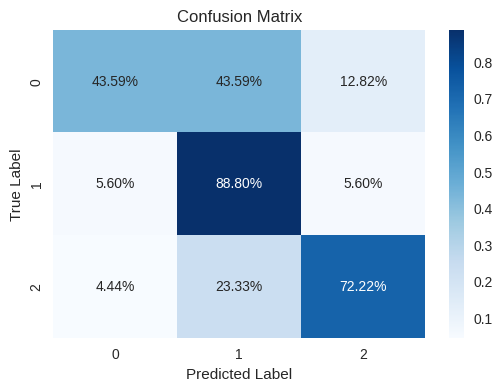

Test Sensitivity: 0.9407, Test Specificity: 0.5000


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


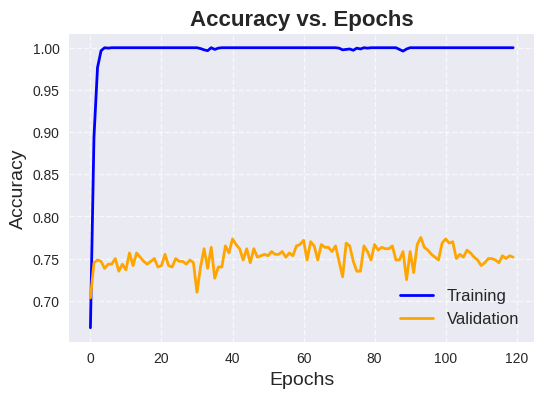

<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


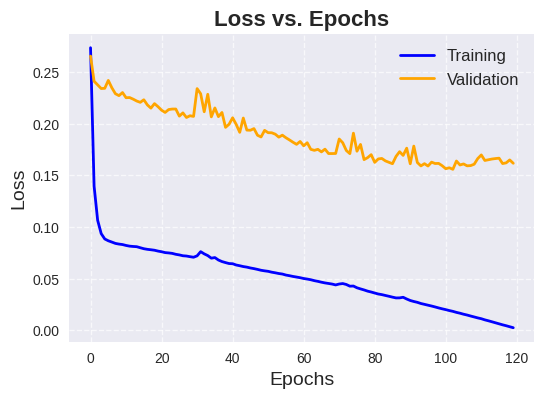

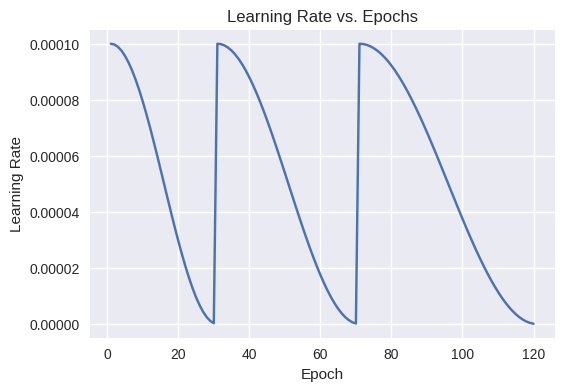

In [16]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)